**Kaggle team name**: [D] - [west_coasters] - [Andrew Rice, Carlos Rivas]
1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`. 
  1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where `🐧` identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

<hr color=darkblue>

# **🏆💎Diamonds**

<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/c/jan-24-diamonds/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive) 
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>


In [ ]:
# from google.colab import drive; drive.mount('/content/gdrive')   # OK to enable, if kaggle.json is stored in Google Drive

In [1]:
#if problem persists clear content folder, carefully

!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
#!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json > log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v jan-24-diamonds         # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

- competition is now set to: jan-24-diamonds
100% 3.30M/3.30M [00:00<00:00, 154MB/s]
Using competition: jan-24-diamonds
 teamId  teamName                                                  submissionDate       score       
-------  --------------------------------------------------------  -------------------  ----------  
8707191  Samuel Nathanson                                          2022-06-12 06:43:33  568.08182   
8076176  JC-AreForever-LeeMerran                                   2022-02-07 02:44:04  571.40711   
8102216  IB-Jötunheimr-Bakhtiyarov, Ivanushkina,Lukianov           2022-02-06 18:11:13  574.83942   
8059629  JG-TBD-Mendola Packard                                    2022-02-01 01:08:03  575.55421   
8056148  JD-TeamRocket-Corson-Hernandez                            2022-02-06 10:02:45  579.18701   
8058107  JA-ABAG-BarrettGivre                                      2022-02-03 02:53:11  579.52731   
8084977  JH-Code Breakers                                          2022-

In [2]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 789 ms, sys: 207 ms, total: 996 ms
Wall time: 1.33 s


In [3]:
df = pd.read_csv('XY_diamonds.csv'); df.head()

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
3,0.28,67.9,60.3,4.30,4.26,2.66,P,E,VS2,NaN
4,0.34,67.5,69.4,5.44,5.50,3.32,P,E,VS2,NaN


In [4]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

In [ ]:
'''

def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))

'''

'\n\ndef ScatterCorrHist(df):\n  def corrdot(*args, **kwargs):\n    # credit: https://stackoverflow.com/questions/48139899\n    corr_r = args[0].corr(args[1], \'pearson\')\n    corr_text = f"{corr_r:2.2f}".replace("0.", ".")\n    ax = plt.gca();\n    ax.set_axis_off();\n    msz = abs(corr_r) * 5000   # marker size\n    fsz = abs(corr_r) * 40 + 5 # font size\n    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap=\'coolwarm\', vmin=-1, vmax=1, transform=ax.transAxes)\n    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha=\'center\', va=\'center\', fontsize=fsz)\n\n  sns.set(style=\'white\', font_scale=.8);\n  g = sns.PairGrid(df, aspect=1, diag_sharey=False);\n  g.fig.set_size_inches(20,10)\n  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={\'color\':\'red\'}, scatter_kws={\'s\':1});\n  g.map_diag(sns.histplot, kde_kws={\'color\':\'black\'});\n  g.map_upper(corrdot);\n  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);\n  _ = plt.su

In [ ]:
#tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
1. Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Perhaps something in EDA or prior experience lead you to these)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

1. The preprocessing pipeline is composed of an outlier filter, a preprocessing function, and a polynomial featurization transformer. First, the data is put through an outlier filter that removes data points outside of 3 standard deviations of the mean. Then, the data is put through a preprocessing function. This function first one hot encodes the categorical features, then ordinally encodes the categorical features and then defines the ratios of these encoded features to the "carat" feature. After this, the "depth" feature is dropped because it is not correlated with the target variable (and thus adds noise), and the categorical features are dropped (because we found we only need the ratios instead of the encoded features). Next, the data is transformed using a degree 2 polynomial transformer. Finally, the data is ready for input into the model.

2. After a significant amount of trial and error, we learned that the linear regression models perform better when the categorical data is one hot encoded instead of ordinally encoded. However, from research we found that computing the ratio of cut, color, and clarity to the carat feature is signficiant, so we decided to ordinally encode the categorical features to compute the ratio (and later dropped the encoding). We decided to drop the "depth" feature because it does not appear to be corrleated with the target variable. Finally, we decided to transform the data with a polynomial transformer at the end purely from trial and error. Several other models we developed that did not include this element showed poor performance (~1100 MAE) but once the data was transformed using the polynomial transformer we found much better results.

3. We evaluated the effectiveness of these elements by removing elements one at a time and looking at how the model performance changes. Adding the polynomial transformer at the end of the pipeline made a big difference in model performance, although the data loses some intepretability because of the complex transformation. 

4. Several different pipelines were attempted before reaching the final version. These pipelines contained a mixture of one hot encoding, ordinal encoding, feature shifting, logarithmic feature scaling, and polynomial transformation. We also attempted to use principal component analysis (PCA) to reduce the dimensionality of the dataset, but it did not yield much better results. Other types of feature engineering were also attempted, including computing the volume of the diamond from the x, y, and z features. 

Start by removing outliers from the dataset.

In [6]:
# Reference 1 (code for removing outliers)
tXY['zscore'] = (tXY.price - tXY.price.mean()) / tXY.price.std()
tXY = tXY[(tXY.zscore>-3) & (tXY.zscore<3)]
tXY_new = tXY.drop('zscore', axis=1)
tX_new, tY_new = tXY_new.drop('price', axis=1), tXY_new.price

Now build preprocessing function. ----REMEMBER THAT the CORRELATION WRT the TARGER VARIABLE can give us AN INDCATION that we CAN DO FEATURE ENGINEERING ON ALL those VARIABLES 

In [7]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

def preprocess(df):
  tXp = pd.get_dummies(df)  # one hot encode categorical data
  # keep the categorical data so we can compute the ratios
  tXp['cut'] = df['cut'] 
  tXp['color'] = df['color']
  tXp['clarity'] = df['clarity']
  
  # Reference 3 - feature scaling
  tXp['cut'] = tXp['cut'].map({'I':1,'G':2,'V':3,'F':4,'P':5})
  tXp['color'] = tXp['color'].map({'E':1,'D':2,'F':3,'G':4,'H':5,'I':6,'J':7})
  tXp['clarity'] = tXp['clarity'].map({'VVS1':1,'IF':2,'VVS2':3,'VS1':4,'I1':5,'VS2':6,'SI1':7,'SI2':8})

  tXp['cut/ct'] = tXp['cut']/tXp['carat']
  tXp['color/ct'] = tXp['color']/tXp['carat']
  tXp['clarity/ct'] = tXp['clarity']/tXp['carat']
  tXp['depth/ct'] = tXp['depth']/tXp['carat']
  tXp['table/ct'] = tXp['table']/tXp['carat']
  tXp['x/ct'] = tXp['x']/tXp['carat']
  tXp['y/ct'] = tXp['y']/tXp['carat']
  tXp['z/ct'] = tXp['z']/tXp['carat']

  # drop remaining unnecessary features
  tXp = tXp.drop(['cut', 'color', 'clarity'], axis=1)#'depth', 'table', 
  
  return tXp

In [8]:
preprocess(tX_new).head()

,carat,depth,table,x,y,z,cut_F,cut_G,cut_I,cut_P,...,clarity_VVS1,clarity_VVS2,cut/ct,color/ct,clarity/ct,depth/ct,table/ct,x/ct,y/ct,z/ct
40000,0.36,69.5,61.3,4.58,4.52,2.84,0,0,0,1,...,0,0,13.89,13.89,11.11,193.06,170.28,12.74,12.56,7.89
40001,0.87,70.7,56.3,6.69,6.74,4.19,0,0,1,0,...,0,0,1.15,4.60,6.90,81.26,64.71,7.69,7.74,4.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40003,0.30,69.6,69.8,5.15,5.11,3.10,0,0,0,1,...,0,0,16.67,6.67,20.00,232.00,232.67,17.15,17.03,10.33
40004,0.60,68.6,49.4,4.88,4.91,2.96,0,0,0,1,...,0,0,8.33,1.67,11.67,114.33,82.33,8.14,8.18,4.93


## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**
1. Our goal during the preprocessing pipeline was to condition the data so that it is best suited for some type of linear regression. Once we got to the modeling portion of the competition, it became an exercise of trying different models and tweaking their hyperparameters to determine what model is best to use. 

2. We evaluated the effectiveness of the models by looking at their MAE and by looking at the distribution of the regression predictions versus the distribution of the actual data. 

3. Four different models were evluated: standard linear regression, Lasso and Ridge regression, and ElasticNet regression. For the three models with regularization parameters, we tuned the hyperparameters but found very little impact on the model score. 

In [9]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


In [10]:
# poly transform data create training/test sets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=2)
tXp = poly.fit_transform(preprocess(tX_new))

X_train, X_test, y_train, y_test = train_test_split(tXp, tY_new, test_size=0.3)

In [11]:
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

m = LinearRegression()
m.fit(X_train,y_train)

y_pred = m.predict(X_test)
print()
print(mean_absolute_error(y_pred, y_test))
print(y_pred.shape)

LinearRegression()


533.3514057044172
(46056,)


Now we need to preprocess the validation data for predictions on the competition data.

In [12]:
vXp = preprocess(vX)
vYp = m.predict(poly.transform(vXp))
vYp

array([  866.5 , 13809.8 , ...,   984.72,  7736.5 ])

Finally, make prediction, view the distributions, and create submission file.

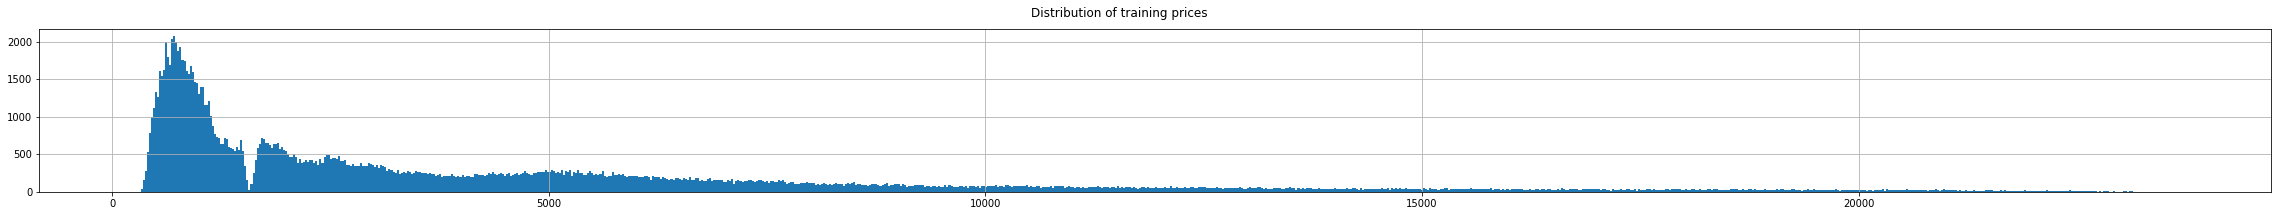

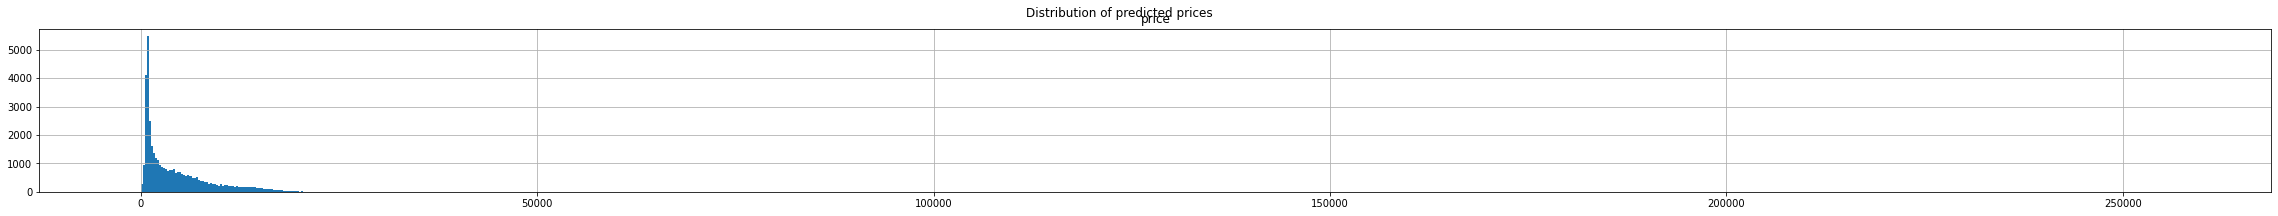

In [13]:
pY = pd.DataFrame(vYp, index=range(1,len(vXp)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'linearModelWithEncodingAndPolyTransforming')

In [14]:
#!kaggle competitions submit -c jan-24-diamonds -f linearModelWithEncodingAndPolyTransforming.csv -m "Message"

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [15]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 14 sec


# **References:**

1. Z-score code https://fivestepguide.com/technology/machine-learning/diamond-price-prediction-using-machine-learning/
2. Diamond clarity https://www.diamonds.pro/education/clarity/
3. Feature scaling https://sp7091.medium.com/regression-approaches-to-predict-diamond-price-258478a485c9
4. Sklearn Documentation


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try 3rd order feature interactions and polynomial features on a small subsample. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features? 
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
